C:\Users\Carl\AppData\Local\Temp\ipykernel_32220\2562572665.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='prescription_num', y='event_interval',


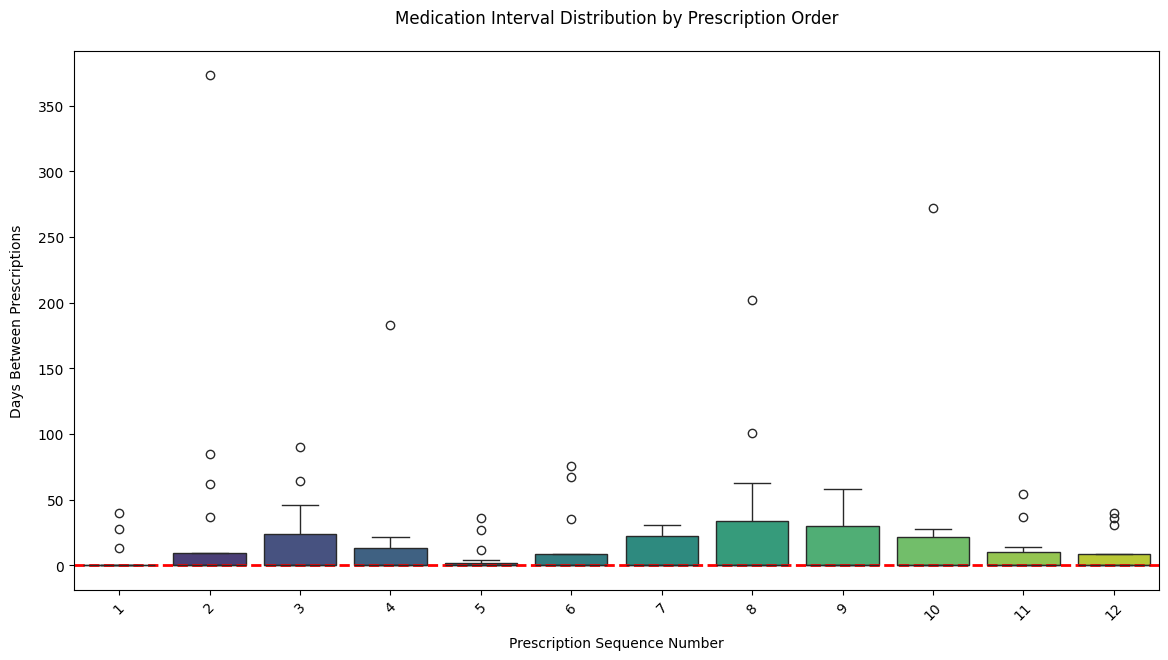

C:\Users\Carl\AppData\Local\Temp\ipykernel_32220\2562572665.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='event_interval',


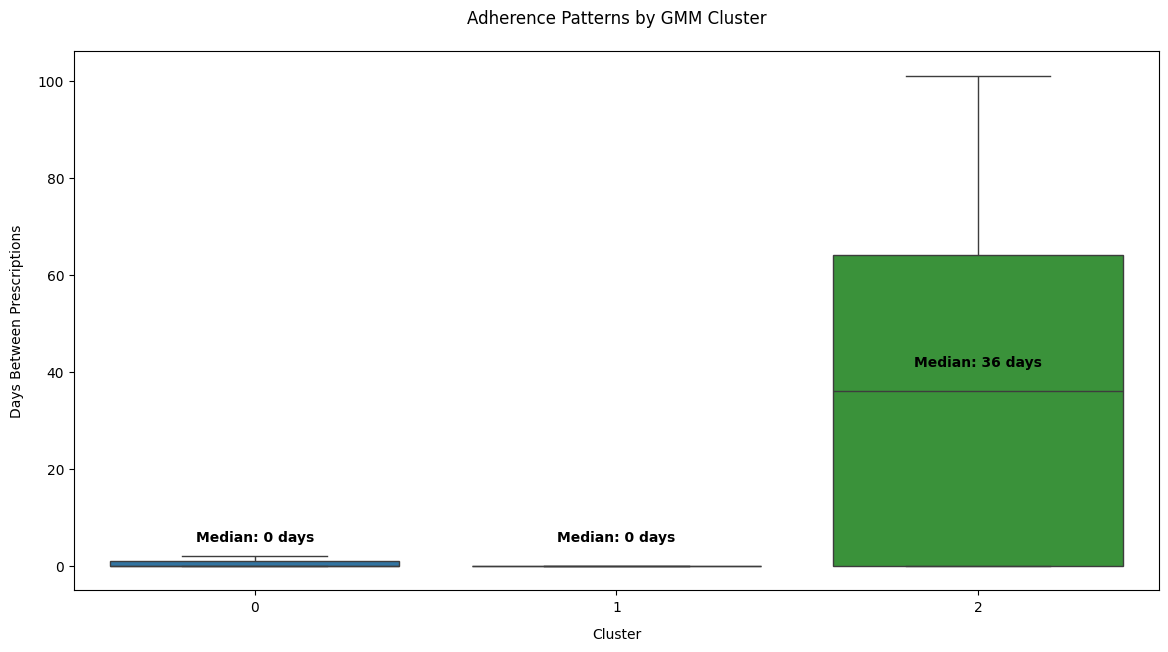

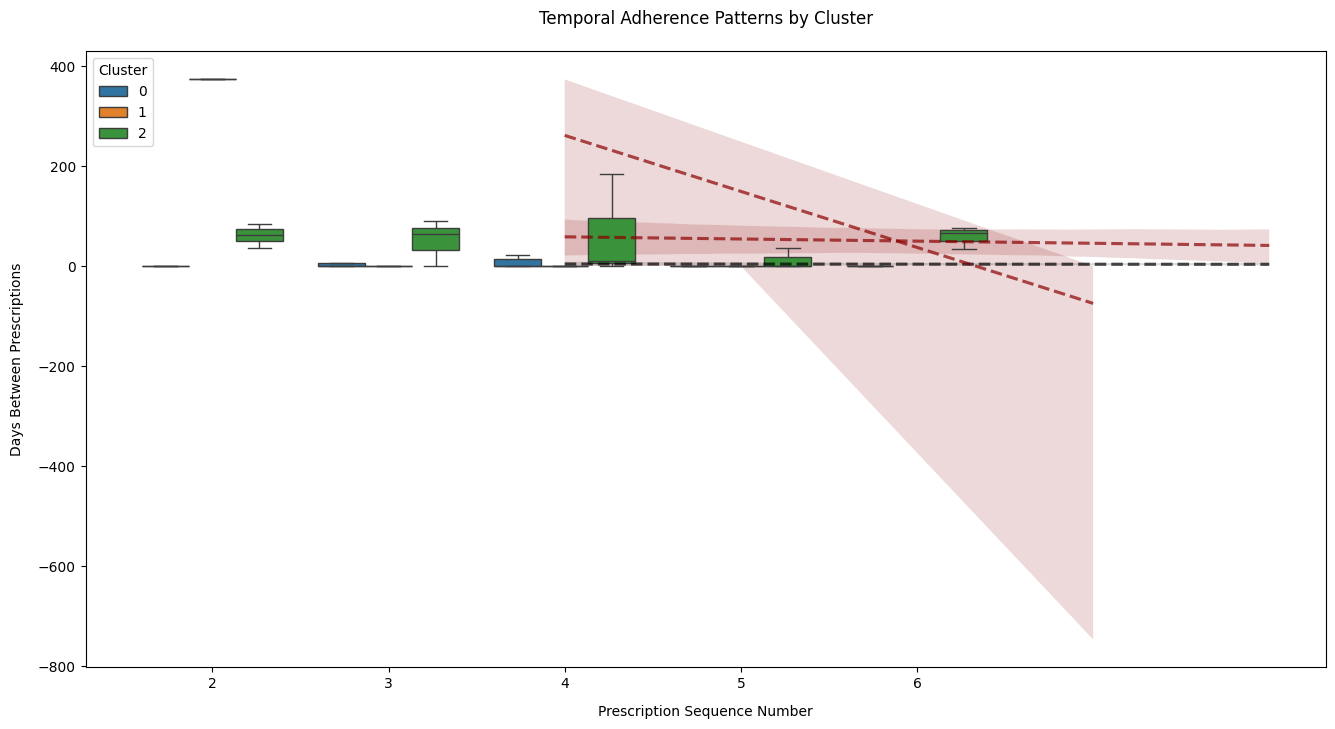

In [14]:
# %% [markdown]
# # Medication Adherence Analysis with SEE and GMM (+ Boxplots)
# 
# **Dataset**: `med_events_ATC.csv`  
# **Techniques**:  
# - Sessa Empirical Estimator (Survival Analysis)  
# - Gaussian Mixture Model (GMM) Clustering  
# - Temporal Pattern Visualization

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ecdf
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# %%
# Load and preprocess data
df = pd.read_csv('med_events_ATC.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values(['PATIENT_ID', 'DATE'])

# Calculate time between prescriptions
df['prev_date'] = df.groupby('PATIENT_ID')['DATE'].shift(1)
df = df.dropna(subset=['prev_date'])
df['event_interval'] = (df['DATE'] - df['prev_date']).dt.days
df = df[df['event_interval'] <= 365*5]

# Create prescription order number
df['prescription_num'] = df.groupby('PATIENT_ID').cumcount() + 1

# %%
# Feature engineering
patient_features = df.groupby('PATIENT_ID').agg(
    mean_interval=('event_interval', 'mean'),
    std_interval=('event_interval', 'std'),
    num_refills=('event_interval', 'count'),
    max_interval=('event_interval', 'max'),
    q25=('event_interval', lambda x: np.quantile(x, 0.25)),
    q75=('event_interval', lambda x: np.quantile(x, 0.75))
).reset_index()
patient_features['std_interval'] = patient_features['std_interval'].fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(patient_features.drop('PATIENT_ID', axis=1))

# %%
# GMM clustering
gmm = GaussianMixture(n_components=3, random_state=42)
patient_features['cluster'] = gmm.fit_predict(scaled_features)
df = df.merge(patient_features[['PATIENT_ID', 'cluster']], on='PATIENT_ID')

# %%
# Boxplot 1: Overall interval distribution by prescription order
plt.figure(figsize=(14, 7))
sns.boxplot(x='prescription_num', y='event_interval', 
            data=df[df['prescription_num'] <= 12],  # First year of treatment
            palette='viridis')

# Calculate median of medians
medians = df.groupby('PATIENT_ID')['event_interval'].median().median()
plt.axhline(medians, color='red', linestyle='--', linewidth=2)

plt.title('Medication Interval Distribution by Prescription Order', pad=20)
plt.xlabel('Prescription Sequence Number', labelpad=10)
plt.ylabel('Days Between Prescriptions', labelpad=10)
plt.xticks(rotation=45)
plt.show()

# %%
# Boxplot 2: Cluster comparison
plt.figure(figsize=(14, 7))
sns.boxplot(x='cluster', y='event_interval', 
            data=df, 
            palette=['#1f77b4', '#ff7f0e', '#2ca02c'],
            showfliers=False)

# Add cluster statistics
cluster_medians = df.groupby('cluster')['event_interval'].median()
for i, median in enumerate(cluster_medians):
    plt.text(i, median+5, f'Median: {median:.0f} days', 
             ha='center', fontweight='bold')

plt.title('Adherence Patterns by GMM Cluster', pad=20)
plt.xlabel('Cluster', labelpad=10)
plt.ylabel('Days Between Prescriptions', labelpad=10)
plt.show()

# %%
# Boxplot 3: Temporal patterns in clusters
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x='prescription_num', y='event_interval', hue='cluster',
                 data=df[df['prescription_num'].between(2, 6)],
                 palette=['#1f77b4', '#ff7f0e', '#2ca02c'],
                 showfliers=False)

# Add trend lines
for cluster in df['cluster'].unique():
    cluster_data = df[(df['cluster'] == cluster) & 
                     (df['prescription_num'].between(2, 6))]
    sns.regplot(x='prescription_num', y='event_interval', 
                data=cluster_data, 
                scatter=False, 
                color='black' if cluster == 0 else 'darkred',
                line_kws={'linestyle':'--', 'alpha':0.7},
                ax=ax)

plt.title('Temporal Adherence Patterns by Cluster', pad=20)
plt.xlabel('Prescription Sequence Number', labelpad=10)
plt.ylabel('Days Between Prescriptions', labelpad=10)
plt.legend(title='Cluster', loc='upper left')
plt.show()